# We will be using Keras, pretty much the highest-level neural network API.  It can use tensorflow, CNTK, or theano as a backend.  If tensorflow is using a GPU, then it is using the NVIDIA CUDA codebase (another API), which then is calling nearly direct commands on the GPU.  So we could have 3 levels of APIs if we are using Keras on a GPU.

data from here: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [280]:
import pandas as pd
import random

In [281]:
filename = "hour.csv"
    # parse dates will convert those columns (labels in the list) to dates

# infer datetime format will try to figure out the datetime format of the dates columns
# and keep using that for the column, so can speed up loading by a lot sometimes
bike_df = pd.read_csv(filename, parse_dates=['dteday'], infer_datetime_format=True)
bike_df.head()
random.seed(42)

In [282]:
# drops the record index 'instant' and date
# also drop casual and registered, because cnt = casual + registered
drop_cols = ['instant', 'dteday', 'casual', 'registered']
bike_df.drop(drop_cols, axis=1, inplace=True)
# if you want, you could engineer more features by getting the day of the month or other properties from the date

In [283]:
bike_df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [284]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


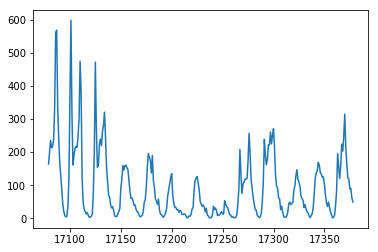

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline
_ = bike_df.iloc[-300:]['cnt'].plot()

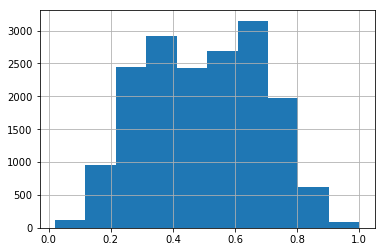

In [286]:
_ = bike_df['temp'].hist()

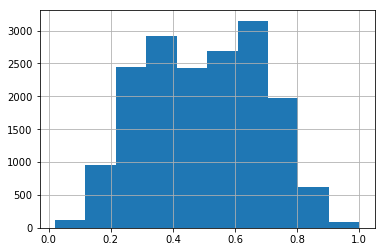

In [287]:
_ = bike_df['temp'].hist()

# 'cnt' is what we are trying to predict.  This is the number of people who rented bikes during that hour.

In [288]:
bike_df.shape

(17379, 13)

In [299]:
cols = bike_df.columns
feat_cols = [c for c in cols if c != 'cnt']
features = bike_df[feat_cols].values
targets = bike_df['cnt'].values

# for time series we typically want to save the last bit as the testing instead of mixing up the timesteps
trainsize = round(0.8 * features.shape[0])
train_features = features[:trainsize]
test_features = features[trainsize:]
train_targets = targets[:trainsize]
test_targets = targets[trainsize:]
print(train_targets.shape)
print(test_targets.shape)

(13903,)
(3476,)


In [300]:
# force to use CPU for testing
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [301]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [302]:
features.shape

(17379, 12)

In [303]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

inputs = Input(shape=(features.shape[1], ))
x = Dense(500, activation='elu')(inputs)
x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
x = Dense(50, activation='elu')(x)
x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
#x = Dense(50, activation='elu')(x)
#x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
#x = Dense(100, activation='elu')(x)
#x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
x = Dropout(0.1)(x)
x = Dense(1, activation='linear')(x)

In [304]:
# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
cb = [checkpoint]

# this compiles our model so it is ready to fit
model = Model(inputs, x)
model.compile(optimizer='adam', loss='mse')

In [305]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               6500      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
__________

In [306]:
subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    #class_weight = 0.5,
                    #sample_weight = ,
                    epochs=399,
                    verbose = 0,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=56),

In [307]:
# check losses for overfitting and performance
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

AttributeError: 'tuple' object has no attribute 'history'

0.0
0.9265759351061683


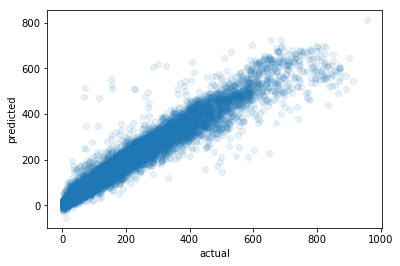

In [308]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print(r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print(r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

-0.11299526466191145
0.7498810742181181


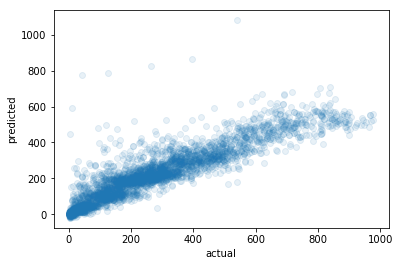

In [309]:
print(r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print(r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

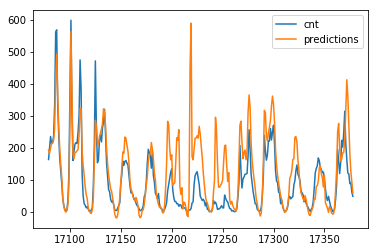

In [310]:
bike_df['cnt'].iloc[-300:].plot()
plt.plot(bike_df.index[-300:], future_preds[-300:], label='predictions')
_ = plt.legend()

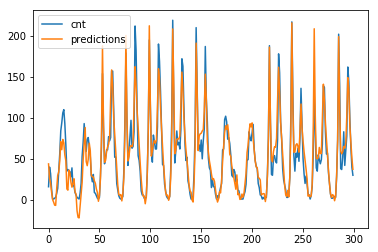

In [311]:
bike_df['cnt'].iloc[:300].plot()
plt.plot(bike_df.index[:300], past_preds[:300], label='predictions')
_ = plt.legend()

# now your turn: try different network hyperparameter settings and see which is best.  Recommendations:

* Change activation functions https://keras.io/activations/
* Change layer sizes
* Change number of layers
* Change dropout rate 
* loss function https://keras.io/losses/

Only do these one at a time.  Don't change network size, activation function, dropout rate all at the same time, or you wont know what made your net better or worse.

Advanced things to try:
* regularization (to prevent overfitting) https://keras.io/regularizers/
* mess around with optimizers https://keras.io/optimizers/
* use sklearn's StandardScaler to z-scale all your features http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html